In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from pathlib import Path

from scipy.signal import find_peaks

import joblib

In [3]:
from __future__ import division, print_function, unicode_literals
import sqlite3
import zlib

import msgpack

try:
    buffer
except NameError:
    # Python 3
    buffer = bytes


class MWK2Reader(object):

    _compressed_text_type_code = 1
    _compressed_msgpack_stream_type_code = 2

    def __init__(self, filename):
        self._conn = sqlite3.connect(filename)
        self._unpacker = msgpack.Unpacker(raw=False, strict_map_key=False)

    def close(self):
        self._conn.close()

    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.close()

    @staticmethod
    def _decompress(data):
        return zlib.decompress(data, -15)

    def __iter__(self):
        for code, time, data in self._conn.execute('SELECT * FROM events'):
            if not isinstance(data, buffer):
                yield (code, time, data)
            else:
                try:
                    obj = msgpack.unpackb(data, raw=False)
                except msgpack.ExtraData:
                    # Multiple values, so not valid compressed data
                    pass
                else:
                    if isinstance(obj, msgpack.ExtType):
                        if obj.code == self._compressed_text_type_code:
                            yield (code,
                                   time,
                                   self._decompress(obj.data).decode('utf-8'))
                            continue
                        elif (obj.code ==
                              self._compressed_msgpack_stream_type_code):
                            data = self._decompress(obj.data)
                self._unpacker.feed(data)
                try:
                    while True:
                        yield (code, time, self._unpacker.unpack())
                except msgpack.OutOfData:
                    pass

In [4]:
def apply_bandpass(data, fs, flow, fhigh):
    wl = flow / (fs / 2.)
    wh = fhigh / (fs / 2.)
    wn = [wl, wh]

    # Designs a 2nd-order Elliptic band-pass filter which passes
    # frequencies between 0.03 and 0.6, an with 0.1 dB of ripple
    # in the passband, and 40 dB of attenuation in the stopband.
    # The question is, do we really want to use IIR filter design?
    # Isn't it the case that IIR filters introduce refractory period
    # artifacts, and thus FIRs are preferred in practice?
    b, a = signal.ellip(2, 0.1, 40, wn, 'bandpass', analog=False)
    # To match Matlab output, we change default padlen from
    # 3*(max(len(a), len(b))) to 3*(max(len(a), len(b)) - 1)
    return signal.filtfilt(b, a, data, padlen=3*(max(len(a),len(b))-1))

In [5]:
def remove_artefacts_ind(signal, samp_on, fs=20000, art_time_usec=900, v_thres = 100):
    for i in range(len(samp_on)):
        pre_ = 1000
        post_ = 2000
        
        
#         peaks = np.where(np.abs(sub_signal) > 150) #find_peaks(-sub_signal, 300)
        sub_signal = apply_bandpass(signal[samp_on[i]-pre_: samp_on[i]+post_], 20000, 1000,5000)
        peaks = find_peaks(-sub_signal, v_thres)
        sub_signal = signal[samp_on[i]-pre_: samp_on[i]+post_]
#         print('Number of Peaks: ', len(peaks[0]))


        art_time_sec = art_time_usec/1e6
        art_len_pre = int(fs*art_time_sec/3)
        art_len_post = int(fs*art_time_sec)
#         print('Artefact length: ', art_len)



        start = -pre_
        x_ = []
        for peak in peaks[0]:
            x_.append(np.arange(start,peak - pre_ - art_len_pre))
            if peak - pre_ > start:
                start = peak - pre_ + art_len_post
        x_.append(np.arange(start, post_))
        x = np.concatenate(x_)
        interpolator_signal = interpolate.interp1d(x, sub_signal[x+pre_], fill_value='extrapolate')
        sig_interp = interpolator_signal(np.arange(-pre_,post_))

        signal[samp_on[i]-pre_: samp_on[i]+post_] = sig_interp
        
    return signal

In [6]:
def remove_artefacts(signal, fs=20000, art_time_usec=900, v_thres = 100, flow=1000, fhigh=5000):
    sub_signal = apply_bandpass(signal, fs = 20000, flow = 1000,fhigh = 5000)
    peaks = find_peaks(-sub_signal, v_thres)
    sub_signal = signal
    post_ = len(signal)

    art_time_sec = art_time_usec/1e6
    art_len_pre = int(fs*art_time_sec/3)
    art_len_post = int(fs*art_time_sec)

    pre_ = 0

    start = -pre_
    x_ = []
    for peak in peaks[0]:
        x_.append(np.arange(start,peak - pre_ - art_len_pre))
        if peak - pre_ > start:
            start = peak - pre_ + art_len_post
    x_.append(np.arange(start, post_))
    x = np.concatenate(x_)
    interpolator_signal = interpolate.interp1d(x, sub_signal[x+pre_], fill_value='extrapolate')
    sig_interp = interpolator_signal(np.arange(-pre_,post_))

    signal = sig_interp
        
    return signal

### Intan header file

To use the utility scripts available on Intan's website, you must first make the `intanutil` package available to your code.

In [7]:
# sys.path.insert(0, '/Users/etotheipiplusone/Dropbox (MIT)/load_intan_rhd_format/')
sys.path.insert(0, '../load_intan_rhd_format/load_intan_rhd_format/')

In [8]:
from load_intan_rhd_format import read_data


In [10]:
rawDataPath = "/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/"
# directory_path = rawDataPath+"intanraw/oleo_stimulation_210816_121924/"
# directory_path = rawDataPath+"intanraw/oleo_stimulation_210813_134444/"
directory_path = rawDataPath+"intanraw/oleo_normalizers-pIT_211206_121917/"


# rawDataPath = "/braintree/data2/active/users/ssazaidi/projects/normalizers/monkeys/oleo/"
# directory_path = rawDataPath+"intanraw/oleo_normalizers_210813_132632/"

# directory_path = "/braintree/data2/active/users/ssazaidi/rough/comb_stimulation/oleo_stimulation-2_210802_154413/"
filename = Path(directory_path+ "info.rhd")

In [11]:
# from load_intan_rhd_format import read_data
# from intanutils import read_data

# filename = Path('oleo_normalizers_210206/info.rhd')
assert filename.exists()
file_data = read_data(filename)
# file_data


Reading Intan Technologies RHD2000 Data File, Version 2.0

n signal groups 11
Found 192 amplifier channels.
Found 18 auxiliary input channels.
Found 6 supply voltage channels.
Found 1 board ADC channel.
Found 2 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.1 seconds


 We are just going to define some constants below.

In [12]:
numChannels = len(file_data['amplifier_channels'])
samplingFrequency = file_data['frequency_parameters']['amplifier_sample_rate'] # in Hz
timeBinSize = 0.01 # in seconds
timeBase = np.arange(-.1, .39, timeBinSize) # in seconds

### Time info

In [13]:
filename = Path(directory_path+'time.dat')
fid = open(filename, 'r')
filesize = os.path.getsize(filename) # in bytes
num_samples = filesize // 4 # int32 = 4 bytes
t = np.fromfile(fid, 'int32', num_samples)
fid.close()

In [14]:
print(t)

[ -101087  -101086  -101085 ... 14792990 14792991 14792992]


In [15]:
t = t / samplingFrequency # in seconds
# print(t)

In [16]:
samplingFrequency

20000.0

### Image presentation times

To extract the time points at which an image/stimuli is presented, we read the digital input data file 02.

In [17]:
filename = Path(directory_path+ 'board-DIGITAL-IN-02.dat')
fid = open(filename, 'r')
filesize = os.path.getsize(filename) # in bytes
num_samples = filesize // 2 # uint16 = 2 bytes
din02 = np.fromfile(fid, 'uint16', num_samples)
fid.close()

Pay particular notice to the sampling rate, $F_s$, measured in Hertz. Typically used values are between 20 kHz and 30 kHz. This is because you want it to be large enough to capture even the biggest voltage changes. Sodium channel depolarization takes about $200 \mu s$, which is 5 Hz. The action potential will rise an fall in this interval. Empirically, it is measured to be about 8 Hz, and the sampling theorem prescribes a frequency of 16 Hz minimum.

In [18]:
len(din02)

14894080

In [19]:
din02[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [20]:
# print( (din02[:-1] < din02[1:]).sum() )
samp_on, = np.nonzero(din02[:-1] < din02[1:]) # Look for 0->1 transitions
samp_on = samp_on + 1 # Previous line returns indexes of 0s seen before spikes, but we want indexes of first spikes
# samp_on = samp_on * 1_000_000 / samplingFrequency # times in us

In [21]:
print(samp_on)

[  120727   125373   130035 ... 14755568 14760238 14764908]


In [22]:
len(samp_on)

1352

### Photodiode

In [23]:
filename = Path(directory_path+'board-ANALOG-IN-1.dat')
fid = open(filename, 'r')
filesize = os.path.getsize(filename) # in bytes
num_samples = filesize // 2 # uint16 = 2 bytes
v_diode = np.fromfile(fid, 'uint16', num_samples)
fid.close()

In [24]:
v_diode = (v_diode - 32768) * 0.0003125

In [31]:
np.max(v_diode)

0.8981250000000001

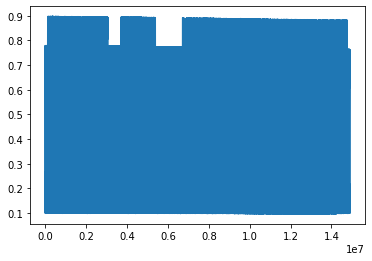

In [30]:
fig = plt.figure(0)
# plt.plot(din02)
plt.plot(v_diode)

In [26]:
len(v_diode)

14894080

In [ ]:
# plt.plot(t[samp_on[30]:samp_on[30]+1000] / samplingFrequency * 1000. - (t[samp_on[30]] / samplingFrequency * 1000.), v[samp_on[30]:samp_on[30]+1000])
# plt.show()

# ##########
# # Analytic 
# ##########
# # from scipy.signal import hilbert, chirp
# # analytic_signal = hilbert(v[6948500:6952000])
# # amplitude_envelope = np.abs(analytic_signal)
# # plt.plot(v[6948500:6952000], label='signal')
# # plt.plot(amplitude_envelope, label='envelope')
# # plt.show()


# ##########
# # Bandpass 
# ##########
# # def _apply_bandpass(data, f_sampling, f_low, f_high):
# #     wl = f_low / (f_sampling / 2.)
# #     wh = f_high / (f_sampling / 2.)
# #     wn = [wl, wh]
    
# #     # Designs a 2nd-order Elliptic band-pass filter which passes
# #     # frequencies between 0.03 and 0.6, an with 0.1 dB of ripple
# #     # in the passband, and 40 dB of attenuation in the stopband.
# #     b, a = signal.ellip(2, 0.1, 40, wn, 'bandpass', analog=False)
# #     # To match Matlab output, we change default padlen from
# #     # 3*(max(len(a), len(b))) to 3*(max(len(a), len(b)) - 1)
# #     return signal.filtfilt(b, a, data, padlen=3*(max(len(a),len(b))-1))

# # filtered_v = _apply_bandpass(v, 20000, 100, 6000)
# # plt.plot(filtered_v[original_t[0]: original_t[0]+1000])
# # plt.show()

# ##########
# # Peak 
# ##########
# # s = v[original_t[0]: original_t[0]+1000]

# # q_u = np.zeros(s.shape)
# # q_l = np.zeros(s.shape)

# # u_x = [0,]
# # u_y = [s[0],]

# # l_x = [0,]
# # l_y = [s[0],]

# # for k in range(1,len(s)-1):
# #     if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
# #         u_x.append(k)
# #         u_y.append(s[k])

# #     if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
# #         l_x.append(k)
# #         l_y.append(s[k])
        
# # u_x.append(len(s)-1)
# # u_y.append(s[-1])

# # l_x.append(len(s)-1)
# # l_y.append(s[-1])

# # u_p = interpolate.interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
# # l_p = interpolate.interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)

# # #Evaluate each model over the domain of (s)
# # for k in range(0,len(s)):
# #     q_u[k] = u_p(k)
# #     q_l[k] = l_p(k)
    
# # plt.plot(s)
# # plt.plot(q_u,'r')
# # plt.plot(q_l,'g')
# # plt.grid(True)
# # plt.show()

In [ ]:
# print(len(samp_on), len(peaks))

In [ ]:
# max(samp_on), max(peaks)

In [ ]:
# THIS WORKS!



# peaks, _ = find_peaks(v_diode, height=1)
# peaks = np.asarray([p for p in peaks if v_diode[p] > 1])
# plt.plot(v_diode)
# plt.plot(peaks, v_diode[peaks], "x")
# plt.show()

p = []

# for i, samp in enumerate(samp_on):
# #     print(f'{i} Sample on (us): {samp}')
#     peak_range = peaks[(peaks >= samp) & (peaks < (samp + 100_000))]
# #     print(f'Peak range {peak_range}')
#     p.append(min( peak_range ))
# #     print(f'Photodiode on (us): {p}')
# #     print(f'Difference: {(p - samp) / samplingFrequency * 1000}')

In [ ]:
# peaks, _ = find_peaks(v_diode, height=0)  # Find all peaks
# peaks = np.asarray([p for p in peaks if v_diode[p] > 1])  # Apply threshold
# photodiode_on = np.asarray([min(peaks[(peaks >= s) & (peaks < (s + 100_000))]) for s in samp_on])
# len(photodiode_on)    

In [ ]:
photodiode_on_ = photodiode_on * 1000 / samplingFrequency
photodiode_on_

In [ ]:
samp_on_ = samp_on * 1000 / samplingFrequency
samp_on_

The average delay between when the signal was sent to when the image was seen is about 36 ms.

In [ ]:
np.mean(photodiode_on_ - samp_on_) # in ms

Note, `photodiode_on` contains trial times.

## MWKReader MWORKS

In [18]:

# filepath = rawDataPath + 'mworksraw/datamaco-stim_corners-20210816-121642.mwk2'

# filepath = rawDataPath + 'mworksraw/datamaco-stim_corners-20210813-134320.mwk2'

filepath = rawDataPath + 'mworksraw/datamaco-stim_corners-20210825-141606.mwk2'

In [19]:
with MWK2Reader(filepath) as event_file:
    code_to_name, name_to_code = {}, {}
    for code, time, data in event_file:
        if code == 0 and not code_to_name:
            code_to_name = dict((c, data[c]['tagname']) for c in data)
            name_to_code = dict((data[c]['tagname'], c) for c in data)
            break
# code_to_name

In [23]:
codes = [
            name_to_code['stim_key'],
            name_to_code['stim_current'],
            name_to_code['stim_id'],
            name_to_code['stim_num_pulses'],
            name_to_code['stim_pulse_period'],
            name_to_code['trial_start_line'],
            name_to_code['correct_fixation'],
            name_to_code['stimulus_presented'], #,
            # Other meta data
            name_to_code['stim_on_time'],
            name_to_code['stim_off_time'],
            name_to_code['stim_on_delay'],
            name_to_code['stimulus_size'],
            name_to_code['fixation_window_size'],
            name_to_code['fixation_point_size_min'],
        ]

data_dict = {
    'code': [],
    'name': [],
    'time': [],
    'data': [],
}
with MWK2Reader(filepath) as event_file:
    for code, time, data in event_file:
        if code in codes:
            data_dict['code'].append(code)
            data_dict['name'].append(code_to_name[code])
            data_dict['time'].append(time)
            data_dict['data'].append(data)
        

In [39]:
codes = [
            name_to_code['stim_num_pulses'],
            name_to_code['stim_pulse_period']
        ]

names = ['stim_num_pulses',
                    'stim_pulse_period']


data_dict = {
    'name': [],
    'data': [],
}
with MWK2Reader(filepath) as event_file:
    for code, time, data in event_file:
        if code in codes and data != 1:
            data_dict['name'].append(code_to_name[code])
            data_dict['data'].append(data)
            
            if (np.all([i in data_dict['name'] for i in names])):
                break


In [40]:
data_dict

{'name': ['stim_pulse_period',
  'stim_pulse_period',
  'stim_pulse_period',
  'stim_num_pulses'],
 'data': [10000, 10000, 10000, 10]}

In [28]:

names = ['stim_num_pulses',
                    'stim_pulse_period']
np.all([i in ['stim_num_pulses', 'stim_pulse_peri'] for i in names])

False

In [ ]:
len(code_to_name_old),  len(code_to_name)

In [ ]:
def get_events(filepath, names, time_range=[]):
    data_dict = {
        'code': [],
        'name': [],
        'time': [],
        'data': [],
    }
    
    with MWK2Reader(filepath) as event_file:
        code_to_name, name_to_code = {}, {}
        for code, time, data in event_file:
            if code == 0 and not code_to_name:
                code_to_name = dict((c, data[c]['tagname']) for c in data)
                name_to_code = dict((data[c]['tagname'], c) for c in data)
                break
        codes = [name_to_code[name] for name in names ]
        
        if time_range:
            for code, time, data in event_file:
                if code in codes and np.any(np.logical_and(time > time_range[0] , time < time_range[1])):
                    data_dict['code'].append(code)
                    data_dict['name'].append(code_to_name[code])
                    data_dict['time'].append(time)
                    data_dict['data'].append(data)
        else:
            for code, time, data in event_file:
                if code in codes:
                    data_dict['code'].append(code)
                    data_dict['name'].append(code_to_name[code])
                    data_dict['time'].append(time)
                    data_dict['data'].append(data)
    data_df = pd.DataFrame(data_dict)
    data_df = data_df.sort_values(by='time').reset_index(drop=True)
    return data_df



In [ ]:
time_range = np.array([[0, 10], [15,20], [100,108], [2, 12]]).T

In [ ]:
number = 25
np.any(np.logical_and(number > time_range[0],  number < time_range[1]))

In [ ]:
%reset -f in


In [ ]:
# eye_events = get_events(filepath, ['eye_h', 'eye_v'], time_range)

In [ ]:
# eye_events

In [ ]:
time_range = [stimulus_presented_df.time.values - 50 * 1000 , stimulus_presented_df.time.values + 300 * 1000 ]

In [ ]:
import pandas as pd
data_df = pd.DataFrame(data_dict)
data_df.head()

In [ ]:
# data_df.loc[data_df['name'] == 'stim_current']

In [ ]:
current_events = data_df.loc[data_df['name'] == 'stim_current'].reset_index(drop=True)
id_events = data_df.loc[data_df['name'] == 'stim_id'].reset_index(drop=True)
key_events = data_df.loc[data_df['name'] == 'stim_key'].reset_index(drop=True)
stimulus_presented_df = data_df[data_df.name == 'stimulus_presented'].reset_index(drop=True)
correct_fixation_df = data_df[data_df.name == 'correct_fixation'].reset_index(drop=True)

In [ ]:
# Drop `empty` data (i.e. -1) before the experiment actually began and after it had already ended
correct_fixation_df = correct_fixation_df[stimulus_presented_df.data != -1].reset_index(drop=True)
stimulus_presented_df = stimulus_presented_df[stimulus_presented_df.data != -1].reset_index(drop=True)


In [ ]:
len(id_events), len(current_events), len(key_events), len(stimulus_presented_df), len(correct_fixation_df)

In [ ]:
current_times = np.array([row.time for i, row in current_events.iterrows()])
id_times = np.array([row.time for i, row in id_events.iterrows()])
key_times = np.array([row.time for i, row in key_events.iterrows()])

In [ ]:
def get_trial_indices(events, df = False, delay_sec= 1):
    if df:
        times = np.array([row.time for i, row in events.iterrows()])
    else:
        times = np.array([i.time for i in events])
#     print(len(times))
    diff_times = np.diff(times)
#     print(len(diff_times))

    trials = []

    mini_trial = [0]

    for i, t in enumerate(diff_times):
        if t < delay_sec*1e6:
            mini_trial.append(i+1)
        else:
            trials.append(mini_trial)
            mini_trial = [i+1]
    trials.append(mini_trial)
    print(i, len(trials))
    return trials

In [ ]:
print(np.min(current_times))
print(np.max(current_times))
print(np.max(current_times) - np.min(current_times))

In [ ]:
(np.max(current_times) - np.min(current_times))/(60*60*1000*1000)

In [ ]:
plt.plot((current_times))
print(current_times[0], current_times[1], np.diff(current_times))

In [ ]:

current_trials = get_trial_indices(current_events, df=True, delay_sec=0.5)
id_trials = get_trial_indices(id_events, df=True, delay_sec = 0.5)
key_trials = get_trial_indices(key_events, df=True,  delay_sec = 0.5)



In [ ]:
# [np.array(current_events.iloc[current_trial].data) for current_trial in current_trials]

In [ ]:
for trial in key_trials:
    if len(trial) > 8:
        print([key_events.iloc[i].data for i in trial])

In [ ]:
h = plt.hist(np.diff(current_times), 'stone')
# h = plt.hist(np.diff(id_times), 'rice' )
# plt.hist(np.diff(key_times), 50)
print(np.median(np.diff(current_times)), np.mean(np.diff(current_times)))

plt.show()

In [ ]:
h[0][0], h[1][1]

In [ ]:
np.sum(np.diff(id_times) < np.mean(np.diff(id_times)))

In [ ]:
# len(id_trials)
# [np.array(id_events.iloc[i].data) for i in id_trials]

In [ ]:
# [(i.data, j.data, i.time, j.time, i.time-j.time) for (_,i), (_,j) in zip(key_events.iterrows(),id_events.iterrows())]


In [ ]:
id_len = 0
for i in id_trials:
    id_len += len(i)
    
print(id_len)

In [ ]:
# key_events.iloc[key_trials[-3]]

In [ ]:
len(current_trials)

In [ ]:
# [[current_trials[i], np.array(current_events.iloc[current_trials[i]].data)] for i in range(len(current_trials))]

In [ ]:
len(current_trials)

In [ ]:
correct_events_df = []

In [ ]:
# for id_trial in id_trials:
#     print(np.array(id_events.iloc[id_trial].data))

In [ ]:
correct_id = []
correct_current = []

curr_idx = 0
while np.all(np.array(current_events.iloc[current_trials[curr_idx]].data) == 1):
    curr_idx += 1

for i in range(len(id_trials)):
#     print((current_times[current_trials[i][0]] - id_times[id_trials[i][0]]), (current_times[current_trials[i+1][0]] - id_times[id_trials[i][0]]))
#     print((current_times[current_trials[i][-1]] - id_times[id_trials[i][-1]]), (current_times[current_trials[i+1][-1]] - id_times[id_trials[i][-1]]))

    
    current_trial = current_trials[curr_idx]
    id_trial = id_trials[i]
    
    if '' in np.array(id_events.iloc[id_trial].data):
#         print(np.array(id_events.iloc[id_trial].data))
#         print('current: ', current_trial, np.array(current_events.iloc[current_trial].data))        
        
        continue



    if len(id_trial) > 8:
        
#         print('ID Trial Number: ', i, "\tCurrent Trial Number: ", curr_idx)
#         print('id', np.array(id_events.iloc[id_trial].data), np.array(id_events.iloc[id_trials[i+1]].data))
#         print('current', np.array(current_events.iloc[current_trial].data), np.array(current_events.iloc[current_trials[curr_idx+1]].data))
#         print()
        id_trial = id_trial[-8:]
        
    if len(id_trial) < 8 or i in [28, 31]:
        print('ID Trial Number: ', i, "\tCurrent Trial Number: ", curr_idx)
        try:
            print('id', np.array(id_events.iloc[id_trial].data), np.array(id_events.iloc[id_trials[i+1]].data))
            print('current', np.array(current_events.iloc[current_trial].data), np.array(current_events.iloc[current_trials[curr_idx+1]].data))
        except:
            print('id', np.array(id_events.iloc[id_trial].data))
            print('current', np.array(current_events.iloc[current_trial].data))

        print()
    
    for idx, j in enumerate(id_trial):
        try:
            correct_current.append(current_trial[idx])
            correct_id.append(j)
        except:
            pass
#             print(i, np.array(id_events.iloc[id_trial+[j]].data))

    if len(id_trial) > 1:
        curr_idx += 1
        
            
        

In [ ]:
curr_idx

In [ ]:
np.array(current_events.iloc[current_trials[-3]].data)

In [ ]:
samp_on_id = np.array(id_events.iloc[correct_id].data)[:len(samp_on)]

In [ ]:
samp_on_current = np.array(current_events.iloc[correct_current].data)[:len(samp_on)]

In [ ]:
len(samp_on_id), len(samp_on_current)

In [ ]:
len(correct_id), len(correct_current)

In [ ]:





correct_id = []
correct_current = []

curr_idx = 0

while np.all(np.array(current_events.iloc[current_trials[curr_idx]].data) == 1):
    curr_idx += 1

for i in range(len(id_trials)):
    current_trial = current_trials[curr_idx]
    id_trial = id_trials[i]
    
    if '' in np.array(id_events.iloc[id_trial].data):
        continue

    if len(id_trial) > 8:
        id_trial = id_trial[-8:]
        
    
    for idx, j in enumerate(id_trial):
        try:
            correct_current.append(current_trial[idx])
            correct_id.append(j)
        except:
            pass

    if len(id_trial) > 1:
        curr_idx += 1
        
samp_on_id = np.array(id_events.iloc[correct_id].data)[:len(samp_on)]

samp_on_current = np.array(current_events.iloc[correct_current].data)[:len(samp_on)]

In [ ]:
%reset -f out

## Artefact Delay Estimate

In [ ]:
%reset -f in

In [ ]:
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid(channel_letters, channel_numbers))
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[0],'-'),np.char.zfill(all_channels[1], 3))
all_channels = all_channels.flatten()

In [ ]:
all_channels

In [ ]:
artefact_delays = {}
# artefact_delays = joblib.load('artefact_delays.pkl')

In [ ]:
# alt_directory_path = "/braintree/data2/active/users/ssazaidi/projects/orthographic/monkeys/oleo/intanraw/oleo_orthographic_210719_145244/"

for channel_name in all_channels:
    
    %reset -f out 
    channel_name = channel_name.upper()
    
    if channel_name in artefact_delays:
        continue
    
    filename = directory_path + 'amp-'+channel_name+'.dat' # amplifier channel data
    # filename = 'oleo_normalizers_210208_134001/amp-C-022.dat'
    fid = open(filename, 'r')
    filesize = os.path.getsize(filename) # in bytes
    num_samples = filesize // 2 # int16 = 2 bytes
    v = np.fromfile(fid, 'int16', num_samples)
    fid.close()


    v = v * 0.195 # convert to microvolts

    sub_samp_on = []
    artefact_on = []
    sub_samp_number = []


    failed_samp_on = []
    failed_stim_number = []

    peaks, _ = find_peaks(np.abs(v), height=150)  # Find all peaks
    peaks = np.asarray([p for p in peaks if np.abs(v[p]) > 100])  # Apply threshold
    for idx, s in enumerate(samp_on):
        try:
            artefact_on.append(min(peaks[(peaks >= s-3_000) & (peaks < (s+2_000))]))
            sub_samp_on.append(s)
            sub_samp_number.append(idx)
        except:
    #         print('Missing stim on: ', s)
            failed_samp_on.append(s)
            failed_stim_number.append(idx)
            pass
    # len(artefact_on)    

    samp_on_ = np.array(samp_on) * 1000 / samplingFrequency
    samp_on_

    sub_samp_on_ = np.array(sub_samp_on) * 1000 / samplingFrequency
    sub_samp_on_

    artefact_on_ = np.array(artefact_on) * 1000 / samplingFrequency
    artefact_on_
    # print(artefact_on,sub_samp_on)
#     print(np.mean(artefact_on_ - sub_samp_on_)) # in ms)


    artefact_delay = np.zeros_like(samp_on, dtype=float)

    artefact_delay[sub_samp_number] = artefact_on_ - sub_samp_on_ # in ms)

    artefact_delay[failed_stim_number] = np.nan

    artefact_delays[channel_name] = artefact_delay

    joblib.dump(artefact_delays, 'artefact_delays.pkl')

all_delays = []
for key in artefact_delays:
    all_delays.append([artefact_delays[key]])
    
all_delays = np.concatenate(all_delays, axis=0)

In [ ]:
plt.plot((np.min(all_delays , axis = 0)))

In [ ]:
np.nanmin(np.min(all_delays , axis = 0))

### Neural data

To extract the neural data, we read the amplifier data files for each channel, for each port.

In [ ]:
directory_path

In [ ]:
# alt_directory_path = "/braintree/data2/active/users/ssazaidi/projects/orthographic/monkeys/oleo/intanraw/oleo_orthographic_210719_145244/"

channel_name = 'F-031'
filename = directory_path + 'amp-'+channel_name+'.dat' # amplifier channel data
# filename = 'oleo_normalizers_210208_134001/amp-C-022.dat'
fid = open(filename, 'r')
filesize = os.path.getsize(filename) # in bytes
num_samples = filesize // 2 # int16 = 2 bytes
v = np.fromfile(fid, 'int16', num_samples)
fid.close()




In [ ]:
v = v * 0.195 # convert to microvolts



In [ ]:
print(v)

In [ ]:
v2 = apply_bandpass(v, 20000,300,5000)

In [ ]:
v=v2

Our raw data looks as follows.

In [ ]:
plt.plot(t, v2)

In [ ]:
# t = [x * 1./samplingFrequency for x in range(len(v))] # time steps
t = np.arange(len(v))/samplingFrequency
plt.plot(t, v)
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [uV]')
plt.show()

In [ ]:
# start_subsize = 3415000
# end_subsize = 3418000
# start_subsize = 6*20000
# end_subsize = 8*20000
# v_copy= np.copy(v[start_subsize:end_subsize])
# t_ = t[start_subsize:end_subsize]

## Artefact Removal

In [ ]:
sub_samp_on = []
artefact_on = []
sub_samp_number = []


failed_samp_on = []
failed_stim_number = []

pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

shift = 0
for idx, s in enumerate(samp_on):
    i = idx
    i +=shift

    sub_signal = v[samp_on[i]-pre_: samp_on[i]+post_]
    band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)


    peaks, _ = find_peaks(np.abs(band_pass_sub_signal), height=0)
    peaks = np.asarray([p for p in peaks if np.abs(band_pass_sub_signal[p]) > 100])  # Apply threshold

    try:
        artefact_time = np.min(peaks)
        artefact_on.append(artefact_time)
        sub_samp_on.append(s)
        sub_samp_number.append(idx)
    except:
#         print('Missing stim on: ', s)
        failed_samp_on.append(s)
        failed_stim_number.append(idx)
        pass


samp_on_ = np.array(samp_on) * 1000 / samplingFrequency
samp_on_

sub_samp_on_ = np.array(sub_samp_on) * 1000 / samplingFrequency
sub_samp_on_

artefact_on_ = 1000* (np.array(artefact_on)/ samplingFrequency - half_)
artefact_on_
# print(artefact_on,sub_samp_on)
print(np.mean(artefact_on_ - sub_samp_on_)) # in ms)




In [ ]:
artefact_on_

In [ ]:
np.std(artefact_on_ - sub_samp_on_)

In [ ]:
np.mean(sub_samp_on_- photodiode_on_[sub_samp_number])

In [ ]:
artefact_delay = np.zeros_like(samp_on, dtype=float)

artefact_delay[sub_samp_number] = artefact_on_ - sub_samp_on_ # in ms)

artefact_delay[failed_stim_number] = np.nan

artefact_delays[channel_name] = artefact_delay

joblib.dump(artefact_delays, 'artefact_delays.pkl')

all_delays = []
for key in artefact_delays:
    all_delays.append([artefact_delays[key]])
    
all_delays = np.concatenate(all_delays, axis=0)


plt.plot((np.mean(all_delays , axis = 0)[:10]))

In [ ]:
# [np.array(id_events.iloc[id_trial].data) for id_trial in id_trials]
id_events.iloc[correct_id].data

In [ ]:
plt.hist(artefact_delay[np.array(id_events.iloc[correct_id].data)== 'd-008'], 15)

In [ ]:
len(failed_samp_on)

In [ ]:
fig=plt.figure(figsize=(12,25), dpi= 100, facecolor='w', edgecolor='k')
pre_ = 5000
post_ = 5000
length_ = pre_+post_
half_ = (length_-post_)/(samplingFrequency)

shift = 0
for i in range(10):
    
    plt.subplot(6,6,i+1)
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v[failed_samp_on[i+shift]-pre_:failed_samp_on[i+shift]+post_])
    plt.plot(0,1, 'k*')
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[failed_samp_on[i+shift]-pre_: failed_samp_on[i+shift]+post_]*1000, alpha=0.5)
    stim_number = failed_stim_number[i]
    plt.title(str(stim_number)+ ' , ' + 
              str(id_events.iloc[correct_id[stim_number]].data) + ' , f' + 
              str(key_events.iloc[correct_id[stim_number]].data) + ' , \n' + 
              str(current_events.iloc[correct_current[stim_number]].data))
    
    plt.xticks([])

In [ ]:
samp_on[6]

In [ ]:
fig=plt.figure(figsize=(12,25), dpi= 100, facecolor='w', edgecolor='k')
pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

shift = 0

bad_samples = [6, 472, 2981,473, 3883, 3884]

for idx in range(6):
    i = idx
    plt.subplot(6,6,i+1)
    i +=shift
    stim_number = bad_samples[i]
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v[samp_on[i]-pre_: samp_on[i]+post_])
    plt.plot(0,1, 'k*')
    
#     plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[sub_samp_on[i]-pre_: sub_samp_on[i]+post_]*500, alpha=0.5)

    plt.plot(artefact_on_[stim_number],0, 'r*')
    plt.title(str(stim_number)+ ' , ' + 
              str(samp_on_id[stim_number]) + ' , f' + 
              str(key_events.iloc[correct_id[stim_number]].data) + ' , \n' + 
              str(samp_on_current[stim_number]))
    plt.xticks([])

In [ ]:
v_copy = np.copy(v)

In [ ]:
np.mean(v_copy), np.mean(v)

In [ ]:
plt.plot(t, (v_copy))
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [mV]')
plt.show()

In [ ]:
len(correct_current)

In [ ]:
plt.figure().clear()
plt.close()

In [ ]:
v_ = remove_artefacts(np.copy(v))

In [ ]:
v2 = remove_artefacts_all(np.copy(v))


In [ ]:

fig=plt.figure(figsize=(25,12), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.plot(v)
plt.subplot(132)
plt.plot(v2)
plt.subplot(133)
plt.plot(v_)

plt.show()

In [ ]:
plt.plot(apply_bandpass(v2[:100000], 20000,300,5000))

In [ ]:
np.max(v2)

In [ ]:
fig=plt.figure(figsize=(12,25), dpi= 100, facecolor='w', edgecolor='k')
pre_ = 5000
post_ = 5000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

shift = 0

for idx in range(36):
    i = idx
    plt.subplot(6,6,i+1)
    i +=shift
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),apply_bandpass(v_[sub_samp_on[i]-pre_: sub_samp_on[i]+post_],20000,1000,5000))
#     plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_[sub_samp_on[i]-pre_: sub_samp_on[i]+post_])
    plt.plot(0,1, 'k*')
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[sub_samp_on[i]-pre_: sub_samp_on[i]+post_], alpha=0.5)
    stim_number = sub_samp_number[i]
    plt.title(str(stim_number)+ ' , ' + 
              str(id_events.iloc[correct_id[stim_number]].data) + ' , f' + 
              str(key_events.iloc[correct_id[stim_number]].data) + ' , \n' + 
              str(current_events.iloc[correct_current[stim_number]].data))
    plt.xticks([])

In [ ]:
fig=plt.figure(figsize=(12,25), dpi= 100, facecolor='w', edgecolor='k')
pre_ = 5000
post_ = 5000
length_ = pre_+post_
half_ = (length_-post_)/(samplingFrequency)

shift = 0
for i in range(32):
    
    plt.subplot(6,6,i+1)
    
    i = i+shift
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),apply_bandpass(v_[failed_samp_on[i+shift]-pre_:failed_samp_on[i+shift]+post_],20000,1000,5000))
    plt.plot(0,1, 'k*')
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[failed_samp_on[i+shift]-pre_: failed_samp_on[i+shift]+post_], alpha=0.5)
    stim_number = failed_stim_number[i]
    plt.title(str(stim_number)+ ' , ' + 
              str(id_events.iloc[correct_id[stim_number]].data) + ' , f' + 
              str(key_events.iloc[correct_id[stim_number]].data) + ' , \n' + 
              str(current_events.iloc[correct_current[stim_number]].data))
    
    plt.xticks([])

In [ ]:
i = 0
pre_ = 400
post_ = 2000
sub_signal = v[samp_on[i]-pre_: samp_on[i]+post_]
peaks = find_peaks(-sub_signal, 150)
# peaks = np.where(np.abs(sub_signal) > 150)

plt.subplot(211)
plt.plot(sub_signal)
plt.title(str(len(peaks[0])))
print('Number of Peaks: ', len(peaks[0]))


fs = 20000
art_time_sec = 900/1e6
art_len_pre = int(fs*art_time_sec/3)
art_len_post = int(fs*2*art_time_sec/3)


print('Artefact length: ', art_len_pre + art_len_post)



start = -pre_
x_ = []
for i in peaks[0]:
    x_.append(np.arange(start,i - pre_ - art_len_pre))
    if i - pre_ > start:
        start = i - pre_ + art_len_post
x_.append(np.arange(start, post_))
x = np.concatenate(x_)
interpolator_signal = interpolate.interp1d(x, sub_signal[x+pre_])
sig_interp = interpolator_signal(np.arange(-400,2000))

plt.subplot(212)
plt.plot(apply_bandpass(sig_interp, 20000,1000,5000))
plt.title(str(len(peaks[0])))

# v[samp_on[i]-pre_: samp_on[i]+post_] = sig_interp

## Artefact Delay across channels

In [ ]:
len(samp_on)

In [ ]:
np.random.shuffle(all_channels)

In [ ]:
# alt_directory_path = "/braintree/data2/active/users/ssazaidi/projects/orthographic/monkeys/oleo/intanraw/oleo_orthographic_210719_145244/"

num_channels = len(all_channels)
num_sample_on = len(samp_on)


pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

shift = 0

data_across_channels = np.zeros([num_channels, num_sample_on, length_])
artefact_times = np.zeros([num_channels, num_sample_on])


for ch_num, channel_name in enumerate(all_channels[:num_channels]):
    
    %reset -f out 
    channel_name = channel_name.upper()

    
    filename = directory_path + 'amp-'+channel_name+'.dat' # amplifier channel data
    # filename = 'oleo_normalizers_210208_134001/amp-C-022.dat'
    fid = open(filename, 'r')
    filesize = os.path.getsize(filename) # in bytes
    num_samples = filesize // 2 # int16 = 2 bytes
    v = np.fromfile(fid, 'int16', num_samples)
    fid.close()


    v = v * 0.195 # convert to microvolts
    
    for idx in range(num_sample_on):
        i = idx
        i +=shift
        
        sub_signal = v[samp_on[i]-pre_: samp_on[i]+post_]
        band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
        
        data_across_channels[ch_num, idx, :] = sub_signal
        peaks, _ = find_peaks(np.abs(band_pass_sub_signal), height=0)
        peaks = np.asarray([p for p in peaks if np.abs(band_pass_sub_signal[p]) > 100])  # Apply threshold
        
        try:
            artefact_time = np.min(peaks)
            artefact_times[ch_num, idx] = artefact_time
        except:
            print(channel_name, idx)
            artefact_times[ch_num, idx] = np.nan
#         print('Artefact Time is: ', artefact_time)




In [ ]:
backup = {'data': data_across_channels, 'artefact_times': artefact_times}
joblib.dump(backup, 'sub_sample_backup.pkl')

In [ ]:
artefact_times_ms = 1000*(artefact_times/samplingFrequency -half_)

## Load Artefact Data

In [ ]:
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid(channel_letters, channel_numbers))
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[0],'-'),np.char.zfill(all_channels[1], 3))
all_channels = all_channels.flatten()
print(all_channels)

In [ ]:
artefact_files = [os.path.join('artefact_delays_'+date+'_'+i+'.pkl') for i in all_channels]

In [ ]:
np.where([i in  ["a-001", "d-003", "b-003", "b-002"] for i in all_channels])

In [ ]:
date = '210820'
file_list = os.listdir(date)
artefact_files = [i for i in file_list if 'artefact' in i]


In [ ]:
len(artefact_files)

In [ ]:
artefact_times_ms = np.zeros([len(artefact_files), len(samp_on)]) 
data_across_channels = np.zeros([len(artefact_files), len(samp_on), length_])
channel_names = []
for i, artefact_file in enumerate(artefact_files):
    try:
        artefact_info = joblib.load(os.path.join(date, artefact_file))
        artefact_times_ms[i,:] = artefact_info['artefact_delay']
        channel_names.append(artefact_file.split('_')[-1].split('.')[0])
        data_across_channels[i, :, :] = artefact_info['data']
    except:
        print(artefact_file.split('_')[-1].split('.')[0])
    

In [ ]:
artefact_times = artefact_times_ms

In [ ]:
h = plt.hist(artefact_times.flatten(), 100)

In [ ]:
hstd = plt.hist(np.nanmedian(artefact_times, axis=0), 100)

In [ ]:
np.where(np.nanmedian(artefact_times, axis=0) < -40)[0]

In [ ]:
artefact_times, np.nanmean(artefact_times, axis=0), np.nanmax(artefact_times, axis=0), np.nanmin(artefact_times, axis=0)

In [ ]:
np.where(np.sum(artefact_times < np.nanmean(artefact_times, axis=0)-2, axis=0) >8)
# plt.hist(np.where(artefact_times < np.nanmean(artefact_times, axis=0)-2)[1], 5312)

In [ ]:
failed_ids = samp_on_id[np.where(np.sum(np.isnan(artefact_times), axis=0))]
failed_currents = samp_on_current[np.where(np.sum(np.isnan(artefact_times), axis=0))]

In [ ]:
failed_df = pd.DataFrame({'ids': failed_ids, 'currents': failed_currents})

In [ ]:
import seaborn as sns

plt.figure(figsize=[15,5])
ax = sns.histplot(data=failed_df, x="ids", hue="currents", palette='inferno', multiple='dodge')


In [ ]:
fig = plt.figure(figsize=(15,5))
plt.hist(samp_on_id[np.where(np.sum(np.isnan(artefact_times), axis=0))], 'stone', rwidth=0.5)
plt.grid()

In [ ]:
  plt.bar(np.arange(num_sample_on)+1, np.sum(np.isnan(artefact_times), axis=0))

In [ ]:
plt.plot(sub_signal)

In [ ]:
bad_samples = np.where(np.isnan(artefact_times))
other_bad = [s for s in bad_samples[1] if s not in b_31_nums[0]]

In [ ]:

bad_samples[1][other_bad[:10]]


In [ ]:
np.where(all_channels == 'b-031')

In [ ]:
b_31_nums = np.where(samp_on_id == 'b-031')

In [ ]:
%reset -f out

In [ ]:
data_across_channels.shape

In [ ]:

pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

fig=plt.figure(figsize=(25,25), dpi= 100, facecolor='w', edgecolor='k')
t = 1000*(np.arange(length_)/samplingFrequency -half_)

count = 0


sub_channels = np.arange(16,21)
sub_samples = [ 8,   61,   63,  157,  192]#, 2055, 2521, 2931, 3530, 3859, 3883,  3884, 4372, 4644, 4883, 4886]

# sub_channels = np.unique(bad_samples[1][other_bad])[:5]
# sub_samples = np.unique([other_bad])[:8]



sub_num_channels = len(sub_channels)
sub_num_sample_on = len(sub_samples)

for i, ch in enumerate(sub_channels):
    for j, sp in enumerate(sub_samples):
        plt.subplot(sub_num_channels, sub_num_sample_on, (j+1) + i*sub_num_sample_on)
        plt.plot(t, apply_bandpass(data_across_channels[ch,sp], samplingFrequency, 300, 5000))
#         plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[samp_on[sp]-pre_: samp_on[sp]+post_]*50, alpha=0.5)
        plt.plot(0,0, 'k*')
        plt.plot(artefact_times[ch][sp], 0, 'r*')
        
        
        plt.title(samp_on_id[sp]+' , '+str(artefact_times[ch][sp]) + ' Curr: ' + str(samp_on_current[sp]))
        plt.ylabel(channel_names[ch])
#         plt.ylim([-3000,3000])
#         plt.yticks([])
        plt.grid(True)
        count +=1
plt.suptitle('Stim Locked Signals')

In [ ]:

pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

fig=plt.figure(figsize=(25,25), dpi= 100, facecolor='w', edgecolor='k')
t = 1000*(np.arange(length_)/samplingFrequency -half_)

count = 0


sub_channels = np.arange(16,21)
sub_samples = [ 8,   61,   63,  157,  192]#, 2055, 2521, 2931, 3530, 3859, 3883,  3884, 4372, 4644, 4883, 4886]

# sub_channels = np.unique(bad_samples[1][other_bad])[:5]
# sub_samples = np.unique([other_bad])[:8]



sub_num_channels = len(sub_channels)
sub_num_sample_on = len(sub_samples)

for i, ch in enumerate(sub_channels):
    for j, sp in enumerate(sub_samples):
        plt.subplot(sub_num_channels, sub_num_sample_on, (j+1) + i*sub_num_sample_on)
        plt.plot(t, apply_bandpass(remove_artefacts(data_across_channels[ch,sp]), samplingFrequency, 300, 5000))
#         plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[samp_on[sp]-pre_: samp_on[sp]+post_]*50, alpha=0.5)
        plt.plot(0,0, 'k*')
        plt.plot(artefact_times[ch][sp], 0, 'r*')
        
        
        plt.title(samp_on_id[sp]+' , '+str(artefact_times[ch][sp]) + ' Curr: ' + str(samp_on_current[sp]))
        plt.ylabel(channel_names[ch])
#         plt.ylim([-3000,3000])
#         plt.yticks([])
        plt.grid(True)
        count +=1

## Please work for the love of god! Artefact Delay Final

In [ ]:
date = '210820'
artefact_times = joblib.load(os.path.join(date, 'artefact_time_'+date+'.pkl')).astype(int)

In [ ]:
artefact_times

In [ ]:
%reset -f out
%reset -f in

In [ ]:
fig=plt.figure(figsize=(20,25), dpi= 100, facecolor='w', edgecolor='k')
pre_ = 200
post_ = 100
length_ = pre_+post_
half_ = (length_-post_)/(samplingFrequency)

shift = 0
for i in range(32):
    
    plt.subplot(6,6,i+1)
    
    i = i+shift
#     plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),apply_bandpass(v[artefact_times[i+shift]-pre_:artefact_times[i+shift]+post_],20000,1000,5000))
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_), apply_bandpass(v[artefact_times[i+shift]-pre_:artefact_times[i+shift]+post_],20000,1000,5000))
    plt.plot(0,0, 'r*')
#     plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[failed_samp_on[i+shift]-pre_: failed_samp_on[i+shift]+post_], alpha=0.5)
    stim_number = i
#     plt.title(str(stim_number)+ ' , ' + 
#               str(id_events.iloc[correct_id[stim_number]].data) + ' , f' + 
#               str(key_events.iloc[correct_id[stim_number]].data) + ' , \n' + 
#               str(current_events.iloc[correct_current[stim_number]].data))
    
    plt.xticks([])

In [ ]:
fig=plt.figure(figsize=(12,25), dpi= 100, facecolor='w', edgecolor='k')
pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)

shift = 0

for idx in range(5):
    i = idx
    i +=shift
    plt.plot(1000*(np.arange(length_)/samplingFrequency -half_),v_diode[sub_samp_on[i]-pre_: sub_samp_on[i]+post_]*500, alpha=0.5)
    stim_number = sub_samp_number[i]
    plt.title(str(stim_number)+ ' , ' + 
              str(id_events.iloc[correct_id[stim_number]].data) + ' , f' + 
              str(key_events.iloc[correct_id[stim_number]].data) + ' , \n' + 
              str(current_events.iloc[correct_current[stim_number]].data))
    plt.xticks([])

In [ ]:
nrSegments = 10
nrPerSegment = int(np.ceil(len(v) / nrSegments))

print(nrPerSegment)

Let us look at the frequency spectogram of the signal.

In [ ]:
spikeTimesMS = []

for i in range(nrSegments):
#     print( i*nrPerSegment, (i+1)*nrPerSegment )
    timeIdxs = 1000 * np.arange(i*nrPerSegment, (i+1)*nrPerSegment) / samplingFrequency # in milliseconds

    # Apply IIR Filter. Maybe not the best thing since
    # this filter introduces refractory period artifacts, and
    # FIR should be preferred
    v1 = apply_bandpass(v[i*nrPerSegment:(i+1)*nrPerSegment], samplingFrequency, 300, 6000)
    v2 = v1 - np.nanmean(v1)

    # We threshold at 3*sd
    # The denominator 0.6745 comes from some old neuroscience
    # paper which shows that when you have spikey data, correcting
    # with this number is better than just using plain standard
    # deviation value
    noiseLevel =  -3 * np.median(np.abs(v2))/0.6745
    outside = np.array(v2) < noiseLevel # Spits a logical array
    outside = outside.astype(int) # Convert logical array to int array for diff to work

    cross = np.concatenate( ([outside[0]], np.diff(outside, n=1) > 0) )

    idxs = np.nonzero(cross)[0]
    spikeTimesMS.extend(timeIdxs[idxs])

In [ ]:
print( len(spikeTimesMS) )
print( spikeTimesMS[0:5] )

Before we move on, let us look how the filtered signal looks like. The grey line is our threshold value.

In [ ]:
i = 3 # We will just look at the first segment
v1 = apply_bandpass(v[i*nrPerSegment:(i+1)*nrPerSegment], samplingFrequency, 300, 6000)
v2 = v1 - np.nanmean(v1)
t = 1000 * np.arange(i*nrPerSegment, (i+1)*nrPerSegment) / samplingFrequency # in milliseconds

plt.plot(t[:10000], v2[:10000])
plt.xlabel('Time [ms]')
plt.ylabel('Voltage [mV]')
plt.axhline(y=-3*np.median(np.abs(v2))/0.6745, color='grey')
plt.show()

Let us add a raster plot to show at which points we're detecting spikes.

In [ ]:
fig = plt.figure()
ax = plt.subplot(211)

plt.plot(t[:10000], v2[:10000])
plt.xlabel('Time [ms]')
plt.ylabel('Voltage [mV]')
plt.xlim(0, t[9999])
plt.axhline(y=-3*np.median(np.abs(v2))/0.6745, color='grey')

ax = plt.subplot(212)
plt.vlines(spikeTimesMS[:10000], 0, 1)
plt.xlim(0, t[9999])
plt.ylim(-2, 2)

plt.show()

Now, let us make this a more intuitive plot. We will pick one image, and for all trials of that image (there should be 6 of them since this FBOP data has 6 repetitions), we will make a raster plot.

Let us pick image 1, which is a monkey face.

For reference,
1-20 = faces
29-40 = bodies
41-60 = objects
61-80 = more faces
81-100 = places
101 = grey
102-126 = normalizers

In [ ]:
np.array(id_events.iloc[correct_id].data)

In [ ]:
# Get all samp_on times for image 1
im1_idxs = np.where(np.array(id_events.iloc[correct_id].data) == 'a-031')[0]
im1_samp_on = np.array(samp_on)[im1_idxs]

# print(im1_samp_on)

In [ ]:
(max_idx - min_idx) * 0.05

In [ ]:
# We're going to plot 200ms interval from stimulus onset time
intervalSize = .25

min_idxs = []
max_idxs = []

for x in im1_samp_on:
    x /= 1000.0 # Convert to sec
    min_idx = min(np.where(t >= x-0.1)[0])
    max_idx = max(np.where(t <= x + intervalSize)[0])
#     print(min_idx, max_idx, (max_idx - min_idx) * 0.05, round((max_idx - min_idx) * 0.05, 2), intervalSize * 1000 )
#     assert( round((max_idx - min_idx) * 0.05, 2) == intervalSize ) # Check that we have a 200ms interval

    min_idxs.append(min_idx)
    max_idxs.append(max_idx)

In [ ]:
fig = plt.figure()
ax = plt.subplot(211)

# For plotting purposes, we're going to threshold the entire
# signal in one segment and not ten
v1 = apply_bandpass(v, samplingFrequency, 1000, 6000)
v2 = v1 - np.nanmean(v1)

plt.plot(t[min_idxs[0]:max_idxs[0]], v[min_idxs[0]:max_idxs[0]])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')

plt.axvspan(t[min_idxs[0]] + 0.07, t[min_idxs[0]] + .17, alpha=0.15, color='g')
plt.axhline(y=-3*np.median(np.abs(v2))/0.6745, color='grey')

In [ ]:
print( min_idxs, max_idxs )
plt.plot(v[1331091:1331091+2000])

# MWorks data extraction

To use MWorks' data analysis tools for Python, you need to make the MWorks package available to your Python code.

In [ ]:
sys.path.insert(0, '/Library/Application Support/MWorks/Scripting/Python/')

In [ ]:
# rawDataPath = '/Users/monkeyd.mani/Dropbox (MIT)/8_10_2021/'

In [ ]:
assert len(fixation_events) == len(image_presented_events) # check for equal length

In [ ]:
image_order = []
fixation_correct = []

for image_presented, fixation in zip(image_presented_events, fixation_events):
    if image_presented.data is -1: # skip if no image presented
        continue
    image_order.append(image_presented.data)
    fixation_correct.append(fixation.data)

In [ ]:
assert len(image_order) == len(fixation_correct) # check for equal length

In [ ]:
print(len(fixation_correct))

In [ ]:
print(image_order[0:5])
print(fixation_correct[0:5])

In [ ]:
import scipy.io as io


mdata = {'image_order': image_order, 'fixation_correct': fixation_correct}
io.savemat('mworksdata.mat', mdata)

In [ ]:
id_events

In [ ]:
from itertools import product
currents = [1,2,4,8,12,16,20,24,28, 32, 36, 40,44]
all_channels_unique = ['a-000', 'd-008',  'd-018', 'a-016', 'd-000', 
                     'a-024', 'd-016', 'a-031', 'd-025', 'a-022', 'd-005', 'b-031', 
                                                            'b-000', 'd-010', 'a-028']


#### FOR STIM DEMO

# all_channels_unique = ['a-000', 'b-008',  'b-018', 'a-016', 'b-000', 
#                      'a-024', 'b-016', 'a-031', 'b-025', 'a-022', 'b-005', 'b-031', 
#                                                             'b-000', 'b-010', 'a-028']



all_channels = list(product(all_channels_unique, currents))

all_refs = ['a-008', 'b-008', 'a-006', 'b-020', 'a-009', 'b-026', 'b-022']

 # Update this list based on the electrodes you want to stimulate (Use LGA to Headstage map)

np.random.seed(1)
np.random.shuffle(all_channels)

In [ ]:
temp = np.array(all_channels).reshape(-1,13, 2)

In [ ]:
len(currents)

In [ ]:
all_channel_ids[0] in all_channel_ids[-8:None]

In [ ]:
np.random.seed(1)
all_channel_ids = np.array([np.random.permutation(all_channels_unique) for i in range(13)]).flatten()
i = 0
chan = all_channel_ids[i]
num_good_ones = 0


back_list = all_channel_ids[i-8:None]

In [ ]:
np.random.seed(1)
all_channel_ids = np.array([np.random.permutation(all_channels_unique) for i in range(13)]).flatten()
i = 0
chan = all_channel_ids[i]
num_good_ones = 0
back_list = all_channel_ids[i-8:None]


while chan not in back_list or i < 195:
    if chan in back_list:
        temp = np.copy(chan)
        swap_num = 1
        while all_channel_ids[i+swap_num] in back_list:
            swap_num += 1
        all_channel_ids[i] = all_channel_ids[i+swap_num]
        all_channel_ids[i+swap_num] = temp
        i = 0
        num_good_ones = 0
        chan = all_channel_ids[i]
    else:
        i = (i+1)%len(all_channel_ids)
        num_good_ones += 1
        try:
            chan = all_channel_ids[i]
        except:
            break
    if i < 8:
        back_list = all_channel_ids[i-8:None]
    else:
        back_list = all_channel_ids[i-8:i]
    
    if chan not in back_list and num_good_ones > 205:
        break



all_currents = np.zeros(all_channel_ids.shape)
for channel in all_channels_unique:
    idxs = np.where(all_channel_ids == channel)
    all_currents[idxs] = np.random.permutation(currents)
all_channels = [(i, j) for i,j in zip(list(all_channel_ids), list(all_currents.astype(int)))]       

In [ ]:
all_channels[-8:] , all_channels[:8]

In [ ]:
import random

random.sample(all_channels_unique, 5)

In [ ]:
all_channels

In [ ]:
stim_idx = 0
stim_key = 1

all_channels[(stim_idx+int(stim_key)-1)%len(all_channels)][0]

In [ ]:
import python_salpa

In [ ]:
sys.path.insert(0, '../../')


In [ ]:
np.ctypeslib.load_library('../../salpa', os.path.dirname('../../python_salpa'))

In [ ]:
libname = 'libsalpa'
loader_path = os.path.dirname('../../python_salpa')
ext = os.path.splitext(libname)[1]

In [ ]:
if not ext:
    # Try to load library with platform-specific name, otherwise
    # default to libname.[so|pyd].  Sometimes, these files are built
    # erroneously on non-linux platforms.
    from numpy.distutils.misc_util import get_shared_lib_extension
    so_ext = get_shared_lib_extension()
    libname_ext = [libname + so_ext]
    # mac, windows and linux >= py3.2 shared library and loadable
    # module have different extensions so try both
    so_ext2 = get_shared_lib_extension(is_python_ext=True)
    if not so_ext2 == so_ext:
        libname_ext.insert(0, libname + so_ext2)
else:
    libname_ext = [libname]

In [ ]:
libname_ext

In [ ]:
loader_path = os.path.abspath(loader_path)
if not os.path.isdir(loader_path):
    libdir = os.path.dirname(loader_path)
else:
    libdir = loader_path

for ln in libname_ext:
    libpath = os.path.join(libdir, ln)
    if os.path.exists(libpath):
        print( ctypes.cdll[libpath])
        ## if no successful return in the libname_ext loop:
# raise OSError("no file with expected extension")

In [ ]:
libpath

In [ ]:
samp_on_id